In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from functions import complex_correlation, colorize, show_colormap_image
import os
import json

# for Jupyter lab
#%matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline

data_folder = '../Data/'

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import torch

from functions import getZernikeCoefs, showZernikeCoefs
from PyTorchAberrations.aberration_functions import pt_to_cpx, cpx_to_pt, tm_to_pt
from PyTorchAberrations.aberration_models import AberrationModes
from PyTorchAberrations.aberration_functions import conjugate, complex_matmul, normalize

# 1. Load data

## 1.1 Load ideal mode bases 

In [3]:
path = os.path.sep.join([data_folder,'conversion_matrices.npz'])
data_dict = np.load(path)
modes_in = data_dict.f.modes_in
nmodes = modes_in.shape[0]
# number of input pixels
m = np.int(np.sqrt(modes_in.shape[1]))
modes_out = data_dict.f.modes_out
# number of output pixels
n = np.int(np.sqrt(modes_out.shape[1]))

## 1.2 Load mask corresponding to degenerate groups of mode

In [4]:
path = os.path.sep.join([data_folder,'mask_near_degenerate.npy'])
mask_near_degenerate = np.load(path)

## 1.3 Load a measured pixel basis TM

In [5]:
# in two parts because of Github 100 Mo size limit
file_path = os.path.sep.join([data_folder, 'TM17_0.npy'])
part1 = np.load(file_path)
file_path = os.path.sep.join([data_folder, 'TM17_1.npy'])
part2 = np.load(file_path)
TM_ref_pix = np.concatenate([part1, part2], axis = 0)
del part1
del part2

In [6]:
TM_ref_pix/=np.max(np.abs(TM_ref_pix))
TM_ref_pix[np.abs(TM_ref_pix)<1e-3] = 0

# 2. Parameters

In [7]:
# padding coefficient for FFT, float > 0.
# the bigger, the more precise the FFT during the calculations
padding_coeff = 0.05

# list of Zernike polynomials to consider in the Fourier plane (both input and output)
list_zernike_ft = list(range(9))

# list of Zernike polynomials to consider in the direct plane (both input and output)
list_zernike_direct = list(range(14))

# learning rate for the optimizer
learning_rate = 30e-2

# number of epoch to train the model
num_epoch = 300

deformation = 'scaling' # for test, do not modify

# 3. Prepare data

## 3.1 Select a quadrant of the pixel TM measured
(it corresponds to one input and one output polarization)

In [8]:
# TM_pix = TM_ref_pix[:n**2,:m**2]
TM_pix = TM_ref_pix[n**2:,m**2:]
# TM_pix = TM_ref_pix[n**2:,:m**2]
# TM_pix = TM_ref_pix[:n**2,m**2:]

## 3.2 Select device (GPU if available)

In [9]:
device_number = 0 # if you have multiple GPUs
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(device_number)}')
    device = torch.device(f'cuda:{device_number}')
else:
    print(f'No GPU available, running on CPU. May be slow.')
    device = torch.device('cpu')

No GPU available, running on CPU. May be slow.


## 3.3 Prepare data for PyTorch

In [10]:
pt_modes_in = cpx_to_pt(modes_in.reshape((-1,m,m)), device, torch.float32).to(device)
pt_modes_in.requires_grad = False

pt_modes_out = cpx_to_pt(modes_out.reshape((-1,n,n)), device, torch.float32).to(device)
pt_modes_out.requires_grad = False

# 4. Prepare optimization

## 4.1 Initialize the model

In [11]:
model = AberrationModes(
    inpoints = m, 
    onpoints = n, 
    padding_coeff = padding_coeff, # if the gpu memory gets full, reduce it to just above 0
    list_zernike_ft = list_zernike_ft,
    list_zernike_direct = list_zernike_direct,
    deformation = deformation
).to(device)

## 4.2 Define the cost function
We want to maximize the energy of the TM projected onto the mode basis.

The cost function (to minimize) is the inverse of the ratio of between 
the norm squared of the TM in the mode basis by the norm squared of the TM in the pixel basis.

In [12]:
def norm_mode_to_norm_pix(T_pix, pt_modes_out, pt_modes_in, onpoints, inpoints):
    '''
    Cost function to minimize.
    It is defined as the inverse of the ratio between the norm squared of the TM
    in the mode basis by the norm squared of the TM in the pixel basis.
    '''
    # reshape the change of basis matrices
    pt_modes_out = pt_modes_out.reshape((-1,onpoints**2,2))
    pt_modes_in = pt_modes_in.reshape((-1,inpoints**2,2))
    # project the TM in the mode basis with the current aberration parameters
    T_mode = complex_matmul(complex_matmul(pt_modes_out,T_pix),conjugate(pt_modes_in.permute((1,0,2))))
    # use the ratio of energy between the projected matrix and the pixel basis
    energy_ratio = (torch.norm(T_mode)/torch.norm(T_pix))**2 
    # the cost function to minimize is the inverse of this quantity
    return 1./energy_ratio

loss_fn = lambda A: norm_mode_to_norm_pix(
                                    tm_to_pt(TM_pix,device),
                                    A[0],
                                    A[1], 
                                    n,
                                    m)

## 4.3 Initialize the optimizer

We use the Adam optimizer

In [13]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate
)

# 5. Optimization 

## 5.1 Calculate energy criteria before optimization

In [14]:
evol_energy_ratio = []
evol_diag_ratio = []
evol_diag_ratio_indx = [0]


TM_modes_before = modes_out @ TM_pix @ modes_in.T.conj()
# ratio of energy after projection to the energy of the full pixel matrix
energy_ratio = (np.linalg.norm(TM_modes_before)/np.linalg.norm(TM_pix))**2
# ratio of the energy on the block diagonal (degenerate groups)
# of the mode basis TM compared to the total energy of the mode basis TM
energy_on_diagonal =np.linalg.norm(TM_modes_before*mask_near_degenerate)**2
diag_ratio = energy_on_diagonal/np.linalg.norm(TM_modes_before)**2

evol_energy_ratio.append(energy_ratio)
evol_diag_ratio.append(diag_ratio)

print(f"Initial ratios: conversion = {100*energy_ratio:.3f}%, \t diagonal = {100*diag_ratio:.3f}%")

Initial ratios: conversion = 60.130%, 	 diagonal = 21.458%


## 5.2 Optimization loop

In [15]:
# get the first guess using the initial parameters
y_pred = model(pt_modes_in,pt_modes_out)

best = 1e8 

import time
t0 = time.time()

for epoch in range(num_epoch):

    # infer the input and output projection matrices from the model
    y_pred = model(pt_modes_in,pt_modes_out)
    # normalize the input and output projection matrices
    y_pred = [normalize(y_pred[0].reshape((-1,n**2,2)),device = device).reshape((-1,n,n,2)), 
              normalize(y_pred[1].reshape((-1,m**2,2)),device = device).reshape((-1,m,m,2))]


    loss = loss_fn(y_pred)

    optimizer.zero_grad() 
    # backward propagation done by autograd
    loss.backward()

    # update the parameters
    optimizer.step()

    evol_energy_ratio.append(1./loss.item())

    if loss.item() < best :
        best  = loss.item()
        best_state = (model.abberation_output.state_dict(),
                      model.abberation_input.state_dict())

    # show some stats
    if epoch % 10 == 0 or epoch == num_epoch-1:
   
        modes_out_corr = pt_to_cpx(y_pred[0].detach().cpu()).reshape(nmodes,-1)
        modes_in_corr = pt_to_cpx(y_pred[1].detach().cpu()).reshape(nmodes,-1)
        # project in the mode basis
        TM_modes_temp = modes_out_corr @ TM_pix @ modes_in_corr.T.conj()
 

        # ratio of energy after projection to the energy of the full pixel matrix
        energy_ratio = (np.linalg.norm(TM_modes_temp)/np.linalg.norm(TM_pix))**2
        # ratio of the energy on the block diagonal (degenerate groups)
        # of the mode basis TM compared to the total energy of the mode basis TM
        energy_on_diagonal =np.linalg.norm(TM_modes_temp*mask_near_degenerate)**2
        diag_ratio = energy_on_diagonal/np.linalg.norm(TM_modes_temp)**2
        
        evol_diag_ratio.append(diag_ratio)
        evol_diag_ratio_indx.append(epoch)
        
        print(f"--| epoch: {epoch+1}/{num_epoch} | {100.*(epoch+1)/num_epoch:3.2f}% |--")
        print(f" Current ratios: conversion = {100*energy_ratio:.3f}%, \t diagonal = {100*diag_ratio:.3f}%")
        
t1 = time.time()

modes_out_corr = pt_to_cpx(y_pred[0].detach().cpu()).reshape(nmodes,-1)
modes_in_corr = pt_to_cpx(y_pred[1].detach().cpu()).reshape(nmodes,-1)
TM_modes_corr = modes_out_corr @ TM_pix @ modes_in_corr.T.conj()

print(f'Computation took {t1-t0:.1f} seconds.')

/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/miniconda/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/spopoff/mycore/Articles/2020/modalTM_MMF/git/article_MMF_disorder/Aberration_correction/PyTorchAberrations/aberration_models.py:99: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torc

--| epoch: 1/300 | 0.33% |--
 Current ratios: conversion = 60.130%, 	 diagonal = 21.458%
--| epoch: 11/300 | 3.67% |--
 Current ratios: conversion = 70.096%, 	 diagonal = 31.234%
--| epoch: 21/300 | 7.00% |--
 Current ratios: conversion = 79.628%, 	 diagonal = 47.783%
--| epoch: 31/300 | 10.33% |--
 Current ratios: conversion = 87.559%, 	 diagonal = 72.800%
--| epoch: 41/300 | 13.67% |--
 Current ratios: conversion = 92.775%, 	 diagonal = 89.469%
--| epoch: 51/300 | 17.00% |--
 Current ratios: conversion = 93.307%, 	 diagonal = 91.444%
--| epoch: 61/300 | 20.33% |--
 Current ratios: conversion = 93.347%, 	 diagonal = 90.787%
--| epoch: 71/300 | 23.67% |--
 Current ratios: conversion = 93.625%, 	 diagonal = 90.940%
--| epoch: 81/300 | 27.00% |--
 Current ratios: conversion = 93.709%, 	 diagonal = 91.230%
--| epoch: 91/300 | 30.33% |--
 Current ratios: conversion = 93.717%, 	 diagonal = 91.871%
--| epoch: 101/300 | 33.67% |--
 Current ratios: conversion = 93.734%, 	 diagonal = 91.784%
--

# 6. Results

## 6.1 Plot evolution

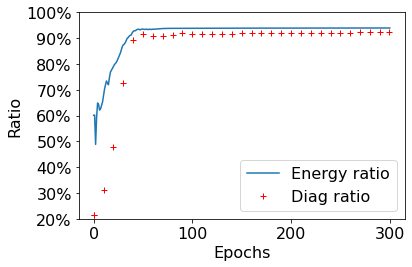

In [16]:
plt.figure()
plt.plot(evol_energy_ratio, label = 'Energy ratio')
plt.plot(evol_diag_ratio_indx, evol_diag_ratio, 'r+', label = 'Diag ratio' )
plt.legend()
yticks = list(np.arange(0.2,1.1,0.1))
plt.yticks(yticks,[f'{y*100:g}%' for y in yticks])
plt.ylim([0.2,1.])
plt.xlabel('Epochs')
plt.ylabel('Ratio')
plt.tight_layout()
# plt.savefig('evolution_optimization.svg')

## 6.2 Mode TM before and after

Text(0.5, 0.98, 'Amplitude of the mode basis TM')

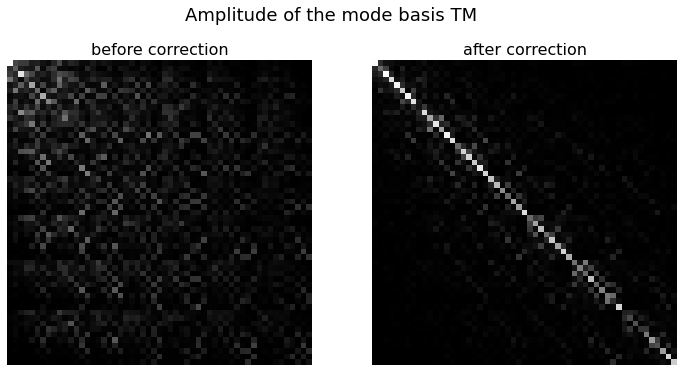

In [17]:
TM_modes_after = TM_modes_temp

fig ,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(np.abs(TM_modes_before), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('before correction')
ax[1].imshow(np.abs(TM_modes_after), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('after correction')
fig.suptitle('Amplitude of the mode basis TM')

## 6.3 Show Zernike coefficients

In [18]:
best_Zernike_coeff = [getZernikeCoefs(model.abberation_output.state_dict()),
                   getZernikeCoefs(model.abberation_input.state_dict())]

/home/spopoff/mycore/Articles/2020/modalTM_MMF/git/article_MMF_disorder/Aberration_correction/functions.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(zernike_names, rotation=40, ha='right')


(<Figure size 864x504 with 2 Axes>,
 <AxesSubplot:xlabel='Name of correction function', ylabel='Amplitude of correction'>,
 [])

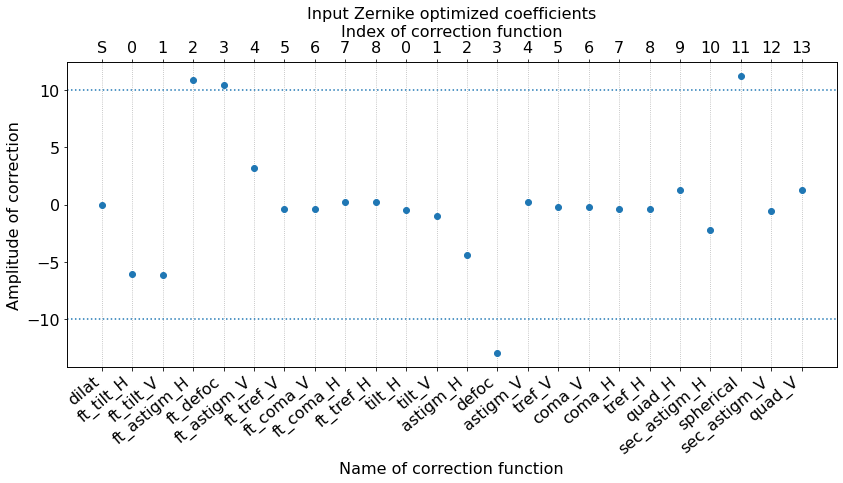

In [19]:
showZernikeCoefs([best_Zernike_coeff[0]], title = 'Input Zernike optimized coefficients')
# plt.savefig('input_zernike.svg')

(<Figure size 864x504 with 2 Axes>,
 <AxesSubplot:xlabel='Name of correction function', ylabel='Amplitude of correction'>,
 [])

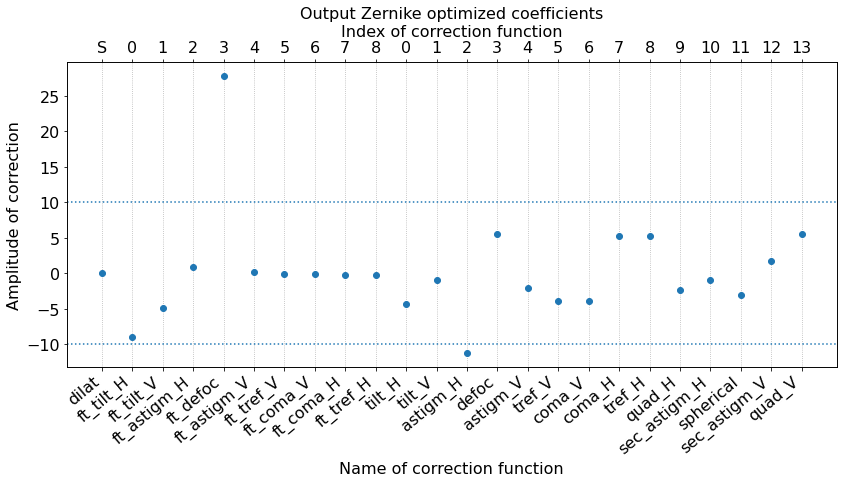

In [20]:
showZernikeCoefs([best_Zernike_coeff[1]], title = 'Output Zernike optimized coefficients')
# plt.savefig('output_zernike.svg')

In [21]:
## Save data for correction comparison
# np.savez('TM_17_optimization_results',
#           dx = 0,
#           best_Zernike_coeff = best_Zernike_coeff,
#           TM_modes_after = TM_modes_after,
#           TM_modes_before = TM_modes_before,
#           TM_pix = TM_pix,
#           model_state_dict = model.state_dict())